In [1]:
import uproot
import numpy as np
import math
from matplotlib import pylab as plt
from ROOT import TTree, TFile, TH2D, TCanvas, TH1F, gROOT
from root_numpy import array2hist, hist2array, fill_hist, tree2array, root2array, list_trees
import pandas as pd
from root_pandas import read_root
from matplotlib import rc

# plt.rcParams['text.usetex'] = True


def midpoints(hvals):
    hvals_shift=np.append(hvals[1:],0)

    midp=(hvals+hvals_shift)/2.0
    return midp[:-1]

font = {'family': 'sanserif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Welcome to JupyROOT 6.22/02


## Inspect what variables are inside the file

In [2]:
file = uproot.open("/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/Skimmed_output3.root")
# print(file.keys())
print(file['PhaseSpace'].keys())

[b'Ekine', b'Weight', b'X', b'Y', b'Z', b'dX', b'dY', b'dZ', b'ParticleName', b'ProductionVolume', b'CreatorProcess']


## Load root files. 
#### * loads all files 
#### Here I am creating a pandas data frame for each fieldsize/dataset and storing it in a dictionary where you access the pandas

In [3]:
filenames_g=[
#             "/work/lb8075/PhaseSpaces/PhS2_10x10_Elec/output*.root",\
            "/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/Skimmed_output*1.root",\
#             "/work/lb8075/PhaseSpaces/PhS2_20x20_Elec/output*.root",\
            "/work/lb8075/PhaseSpaces/PhS2_20x20_p1_Elec_v2/Skimmed_output*1.root",\
            "/work/lb8075/PhaseSpaces/PhS2_30x30_p1_Elec_v2/Skimmed_output*1.root",\
            "/work/lb8075/PhaseSpaces/PhS2_40x40_p1_Elec_v2/Skimmed_output*1.root"
]


data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','Weight','Ekine'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is



/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/Skimmed_output*1.root   

/work/lb8075/PhaseSpaces/PhS2_20x20_p1_Elec_v2/Skimmed_output*1.root   

/work/lb8075/PhaseSpaces/PhS2_30x30_p1_Elec_v2/Skimmed_output*1.root   

/work/lb8075/PhaseSpaces/PhS2_40x40_p1_Elec_v2/Skimmed_output*1.root   



In [4]:
# for files_g in filenames_g:
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
for j,files_g in enumerate(filenames_g):

    df=data_frame_dict[files_g]
    data_frame_dict[files_g]['dZ']=np.sqrt(1-(pow(data_frame_dict[files_g]['dX'],2)+pow(data_frame_dict[files_g]['dY'],2)))
    data_frame_dict[files_g]['dXdY']=(data_frame_dict[files_g].dX**2+data_frame_dict[files_g].dY**2)**0.5
    ratioThetaXY=data_frame_dict[files_g].dXdY/data_frame_dict[files_g].dZ
    ratioThetaX=data_frame_dict[files_g].dX/data_frame_dict[files_g].dZ
    ratioThetaY=data_frame_dict[files_g].dY/data_frame_dict[files_g].dZ
    data_frame_dict[files_g]['thetaXY']=ratioThetaXY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaX']=ratioThetaX.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaY']=ratioThetaY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['XY']=(data_frame_dict[files_g].X**2+data_frame_dict[files_g].Y**2)**0.5

### Checking how many entries in files with different weights

In [5]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['Weight'].value_counts())

1.0    453703
Name: Weight, dtype: int64
1.0    1827529
Name: Weight, dtype: int64
1.0    3634345
Name: Weight, dtype: int64
1.0    5453569
Name: Weight, dtype: int64


### ..and total entries (without taking into account the weight)

In [6]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['X'].count())

453703
1827529
3634345
5453569


### ..and with the weight, so we take into account the biasing 

In [7]:
for files_g in filenames_g:
    df=data_frame_dict[files_g]
    print(df['Weight'].sum(axis = 0, skipna = True) ) 
    #skipping if there are any NANs


453703.0
1827529.0
3634345.0
5453569.0


In [8]:
# # for files_g in filenames_g:
# plt.subplots(1,1,figsize=(19,4))
# # creating a temporary dataframe to hold the one we're currently interating over
# df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS2_10x10_p1_Elec_v2/Skimmed_output*.root"]
# df['ProductionVolume']=df['ProductionVolume'].astype('str')

# # plt.hist(df['ProductionVolume'])
# # print(df.dtypes)
# # df['ProductionVolume']=df['ProductionVolume'].astype('str')
# # print(df.dtypes)

# df['Weight'].astype('float16')
# # print(df.dtypes)

# # print(df2)
# # _=plt.hist(df3)
# #     plt.xlim(-100,100)
# #     plt.ylim(-100,100)
# #     plt.xlabel('X')
# #     plt.ylabel('Y')
# #     plt.colorbar()
# # plt.show()
# # df2=df['ProductionVolume']
# # print(df['ProductionVolume'].dtypes)
# # df['ProductionVolume']=df['ProductionVolume'].astype('str')
# # print(df['ProductionVolume'].dtypes)

# _=plt.hist(df['ProductionVolume'])

### Plotting XY plane distributed electrons

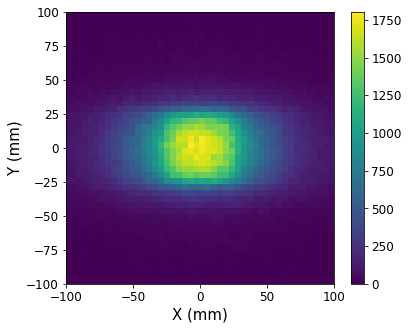

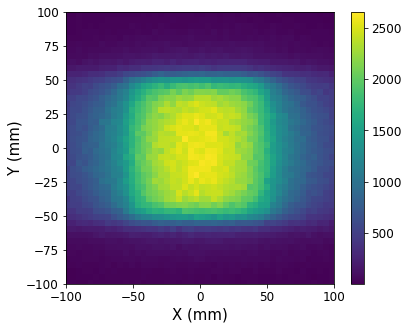

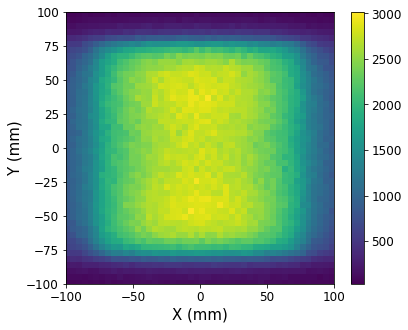

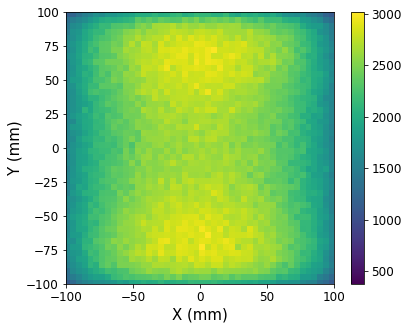

In [11]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['X'],df['Y'],bins=(50,50))
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.colorbar()
    plt.show()
    fieldsize=files_g.split('_')[1]
    savename=f"Phase2_e_{fieldsize}norm.png"
    fig.savefig(savename)

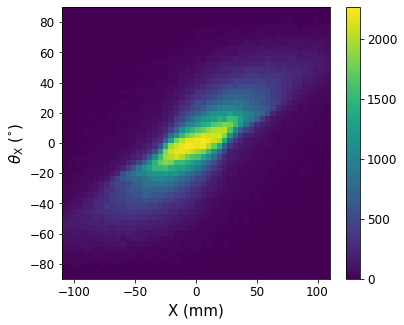

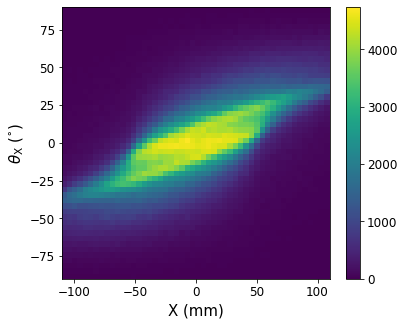

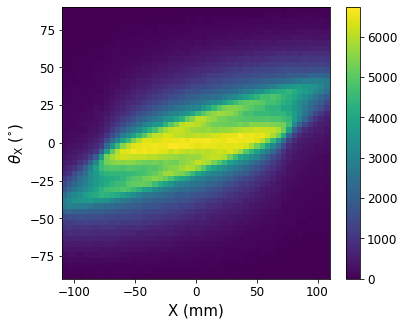

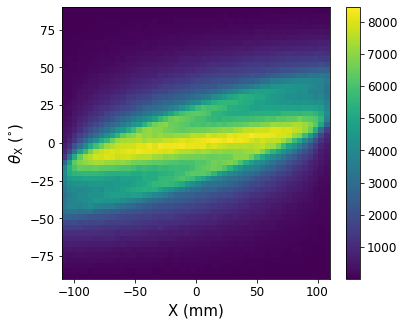

In [12]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['X'],df['thetaX'],bins=(50,50))
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
    plt.xlabel('X (mm)')
    plt.ylabel(r'$\theta_{\rm{X}}$ ($^{\circ}$)')
    plt.colorbar()
    plt.show()
    fieldsize=files_g.split('_')[1]

    savename=f"Phase2_e_{fieldsize}XthetaX.png"
    fig.savefig(savename)

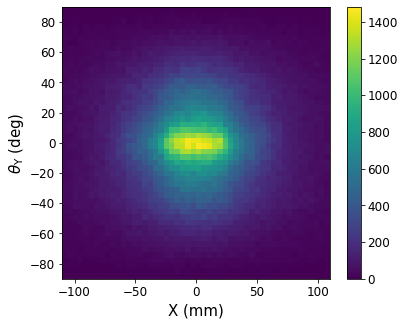

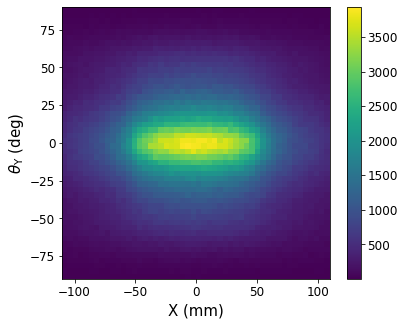

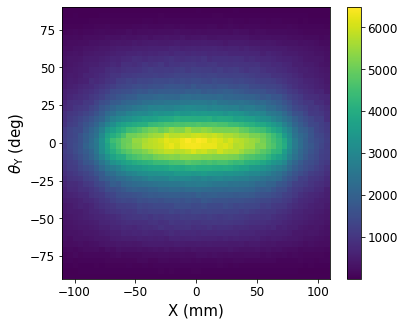

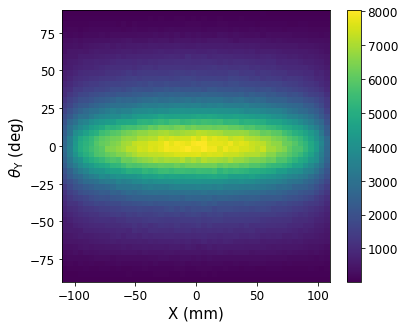

In [13]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['X'],df['thetaY'],bins=(50,50))#,vmax=8100
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
    plt.xlabel('X (mm)')
    plt.ylabel(r'$\theta_{\rm{Y}}$ (deg)')
    plt.colorbar()
    plt.show()
    fieldsize=files_g.split('_')[1]

    savename=f"Phase2_e_{fieldsize}XthetaY.png"
    fig.savefig(savename)

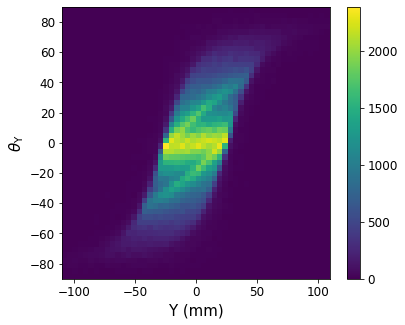

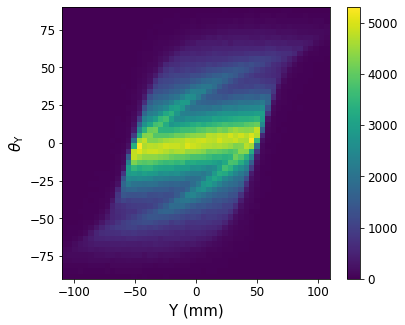

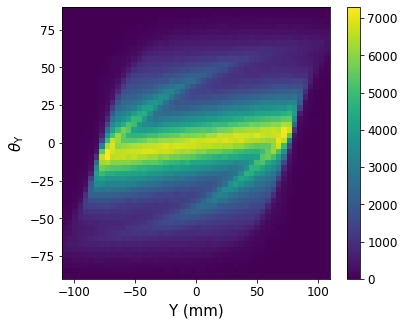

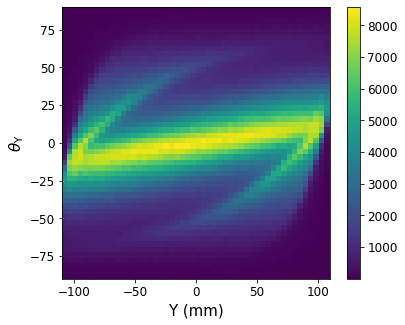

In [14]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['Y'],df['thetaY'],bins=(50,50))
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
    plt.xlabel('Y (mm)')
    plt.ylabel(r'$\theta_{\rm{Y}}$')
    plt.colorbar()
    plt.show()
    fieldsize=files_g.split('_')[1]

    savename=f"Phase2_e_{fieldsize}YthetaY.png"
    fig.savefig(savename)


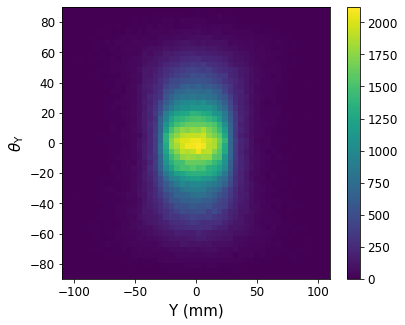

Phase2_e_10x10YthetaX.png


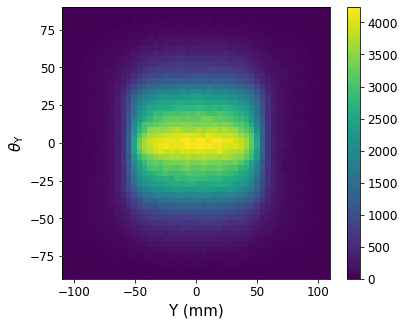

Phase2_e_20x20YthetaX.png


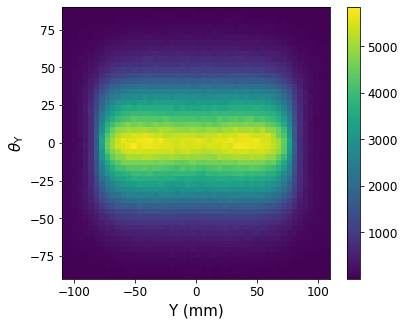

Phase2_e_30x30YthetaX.png


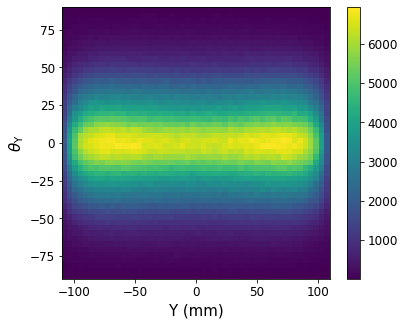

Phase2_e_40x40YthetaX.png


In [15]:
for files_g in filenames_g:
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['Y'],df['thetaX'],bins=(50,50))
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
    plt.xlabel('Y (mm)')
    plt.ylabel(r'$\theta_{\rm{Y}}$')
    plt.colorbar()
    plt.show()
    fieldsize=files_g.split('_')[1]

    savename=f"Phase2_e_{fieldsize}YthetaX.png"
    print(savename)
    fig.savefig(savename)


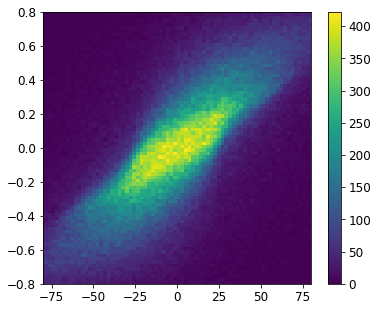

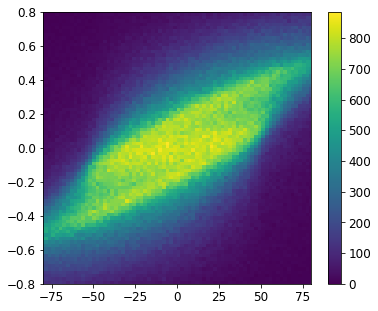

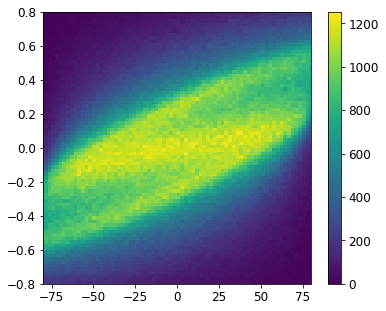

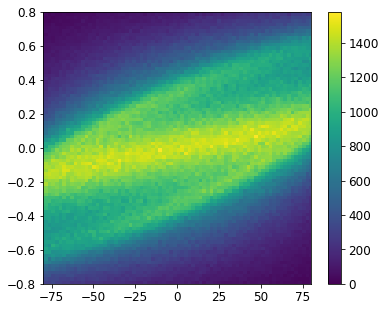

In [17]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(6,5))
    df=data_frame_dict[files_g]
    
    _=plt.hist2d(df['X'],df['dX'],bins=(100,100))
    #using _ just suppresses the output of plt.hist2d
    plt.xlim(-80,80)
    plt.ylim(-0.8,0.8)
    plt.colorbar()
    plt.show()


80
81
[5.97771349e-01 7.30966288e-01 7.34045326e-01 6.86054802e-01
 6.25111083e-01 5.71347363e-01 5.25838650e-01 4.86965794e-01
 4.55073861e-01 4.21204443e-01 3.89989367e-01 3.63180501e-01
 3.37592633e-01 3.16331345e-01 2.96928096e-01 2.77538120e-01
 2.60311433e-01 2.44796797e-01 2.31073843e-01 2.19169114e-01
 2.04238434e-01 1.90502208e-01 1.78929272e-01 1.68710051e-01
 1.60693934e-01 1.50474713e-01 1.40507655e-01 1.31204182e-01
 1.23387141e-01 1.17335239e-01 1.10221599e-01 1.03678643e-01
 9.54634514e-02 8.84559855e-02 8.46204596e-02 8.01346197e-02
 7.43348799e-02 6.90660087e-02 6.42483759e-02 5.92980260e-02
 5.54492284e-02 5.16667894e-02 4.83355888e-02 4.58935931e-02
 4.25756641e-02 3.87268666e-02 3.56478285e-02 3.24095299e-02
 2.94101221e-02 2.77511576e-02 2.52162599e-02 2.23097542e-02
 2.05977028e-02 1.86202172e-02 1.71470567e-02 1.58597003e-02
 1.41343773e-02 1.23294239e-02 1.09757089e-02 1.06306443e-02
 9.64853735e-03 8.02938803e-03 7.23308508e-03 6.33060841e-03
 5.28214287e-03 4.

80
81
[6.60705423e-01 8.17703424e-01 8.14978131e-01 7.52052234e-01
 6.75450380e-01 6.05338420e-01 5.48384412e-01 5.00434430e-01
 4.56549291e-01 4.18141134e-01 3.87070813e-01 3.58042811e-01
 3.32056844e-01 3.08515722e-01 2.85842339e-01 2.67266794e-01
 2.48790230e-01 2.32705722e-01 2.18310499e-01 2.03704115e-01
 1.89889584e-01 1.77285928e-01 1.66338564e-01 1.56126964e-01
 1.46245301e-01 1.36706775e-01 1.27890815e-01 1.19734732e-01
 1.12179137e-01 1.05461586e-01 9.82590259e-02 9.13138175e-02
 8.54442092e-02 8.00332155e-02 7.43153789e-02 6.91584380e-02
 6.50836958e-02 6.07647990e-02 5.62776335e-02 5.25625245e-02
 4.81974363e-02 4.44790278e-02 4.16085617e-02 3.81145115e-02
 3.53727214e-02 3.27662062e-02 3.01003020e-02 2.76884505e-02
 2.54976580e-02 2.31616924e-02 2.13206348e-02 1.96676422e-02
 1.77902914e-02 1.60185209e-02 1.45041025e-02 1.29170977e-02
 1.13531885e-02 1.03072831e-02 9.27787451e-03 8.21547209e-03
 7.22565618e-03 6.34801940e-03 5.57596299e-03 4.81380473e-03
 4.24960966e-03 3.

80
81
[7.67589875e-01 9.44041237e-01 9.17061672e-01 8.21903403e-01
 7.20145950e-01 6.33605757e-01 5.63048727e-01 5.06212426e-01
 4.58958296e-01 4.16156811e-01 3.78872842e-01 3.47667380e-01
 3.19925272e-01 2.94311230e-01 2.72620754e-01 2.52944131e-01
 2.34792592e-01 2.18060324e-01 2.02028453e-01 1.88294287e-01
 1.75661945e-01 1.63429350e-01 1.52579073e-01 1.42037845e-01
 1.32737848e-01 1.24165122e-01 1.15654541e-01 1.07938416e-01
 1.00825270e-01 9.41505027e-02 8.73967934e-02 8.17717817e-02
 7.72099627e-02 7.23962022e-02 6.70063358e-02 6.18432166e-02
 5.80204257e-02 5.43958287e-02 4.99566212e-02 4.60347333e-02
 4.31558829e-02 4.01258676e-02 3.69665224e-02 3.42707494e-02
 3.16824714e-02 2.93814065e-02 2.68267207e-02 2.44265589e-02
 2.28913960e-02 2.10337480e-02 1.88653723e-02 1.70799476e-02
 1.56052506e-02 1.42447670e-02 1.28187786e-02 1.14515766e-02
 1.04858012e-02 9.65607421e-03 8.65502703e-03 7.63550415e-03
 6.76042767e-03 6.05163252e-03 5.41841979e-03 4.77512941e-03
 4.05457699e-03 3.

80
81
[8.71583824e-01 1.05268760e+00 9.91553407e-01 8.68487106e-01
 7.47455145e-01 6.49724295e-01 5.72205748e-01 5.10115414e-01
 4.58603651e-01 4.12688585e-01 3.72095579e-01 3.38088186e-01
 3.09703485e-01 2.84149907e-01 2.60292743e-01 2.39006760e-01
 2.20816365e-01 2.05524905e-01 1.90179196e-01 1.75505950e-01
 1.63299907e-01 1.51419358e-01 1.40115205e-01 1.30733505e-01
 1.21886384e-01 1.13569322e-01 1.06238915e-01 9.92046170e-02
 9.29173745e-02 8.65238942e-02 8.02626461e-02 7.53101570e-02
 7.00932037e-02 6.50898561e-02 6.07194145e-02 5.65535371e-02
 5.28973751e-02 4.91993960e-02 4.57466680e-02 4.27539271e-02
 3.94096972e-02 3.66339526e-02 3.39723570e-02 3.08824198e-02
 2.85779640e-02 2.66442103e-02 2.44991112e-02 2.26975896e-02
 2.10520341e-02 1.93160635e-02 1.75269740e-02 1.59820054e-02
 1.48258219e-02 1.35950458e-02 1.22953283e-02 1.10995881e-02
 9.97844040e-03 9.03586261e-03 8.19048110e-03 7.27050709e-03
 6.53023317e-03 5.88602533e-03 5.25085900e-03 4.68011346e-03
 4.01443202e-03 3.

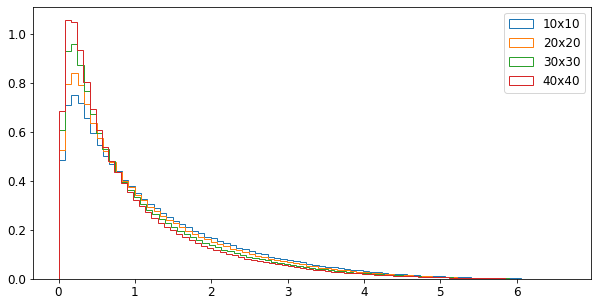

In [11]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

nbins=80
for files_g in filenames_g:
        df=data_frame_dict[files_g]
        y,x,_=plt.hist(df['Ekine'],density=True,histtype='step',bins=(nbins),label=files_g[30:-33])
        mpy=midpoints(y)
        print(len(y))
        print(len(x))
        print(f"{midpoints(y)} and x {x}")
        
        for ij in range(0,nbins-1):
            print(f"/gate/source/mybeam/gps/hist/point {mpy[ij]} {x[ij]}")

# plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
# plt.ylim(0.001,1.2)
plt.show()
fig.savefig("Phase2_Ekine_all.png")


    

In [ ]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(6,5))
    # creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['X'],df['Y'],bins=(50,50),weights=df['Weight'],vmax=6000)
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar()
    plt.show()


In [ ]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(8,4))
    df=data_frame_dict[files_g]
    
    _=plt.hist2d(df['X'],df['dX'],weights=df['Weight'],bins=(100,100),vmax=3050)
    #using _ just suppresses the output if plt.hist2d
    plt.xlim(-80,80)
    plt.ylim(-0.8,0.8)
    plt.colorbar()
    plt.show()


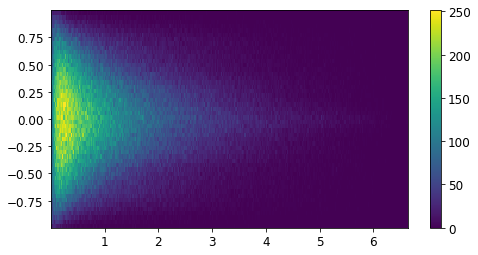

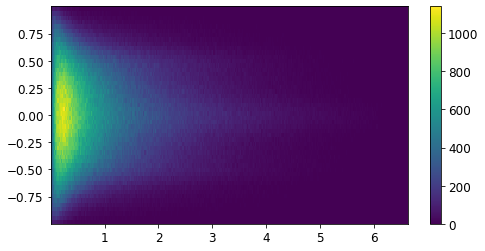

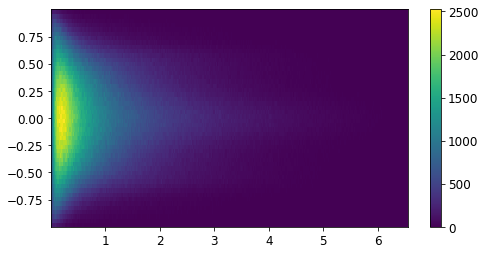

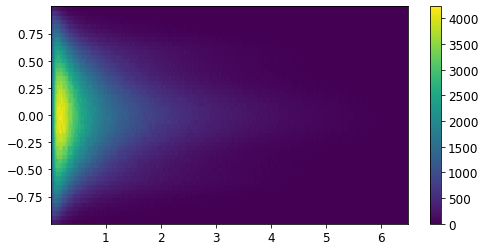

In [21]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(8,4))
    df=data_frame_dict[files_g]
    _=plt.hist2d(df['Ekine'],df['dX'],weights=df['Weight'],bins=(300,50))
#     plt.xlim(-80,80)
#     plt.ylim(-0.7,0.7)
    plt.colorbar()
    plt.show()


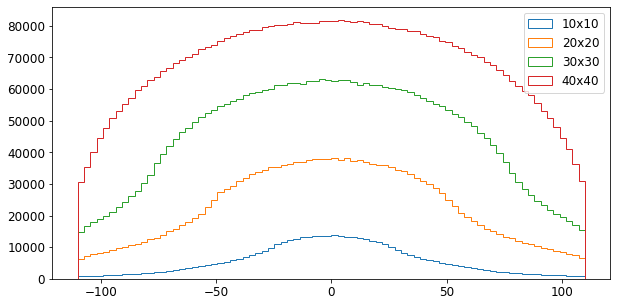

In [24]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:
        df=data_frame_dict[files_g]
        y,x,_=plt.hist(df['X'],histtype='step',bins=(80),label=files_g[30:-33])
#         print(f"{midpoints(y)} and x {x}")

# plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
# plt.ylim(0.001,1.2)
plt.show()


    

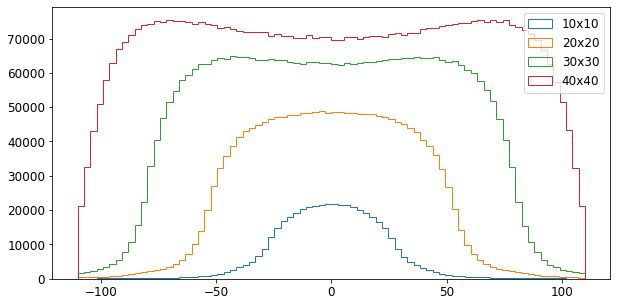

In [25]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:
        df=data_frame_dict[files_g]
        y,x,_=plt.hist(df['Y'],histtype='step',bins=(80),label=files_g[30:-33])
#         print(f"{midpoints(y)} and x {x}")

# plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
# plt.ylim(0.001,1.2)
plt.show()


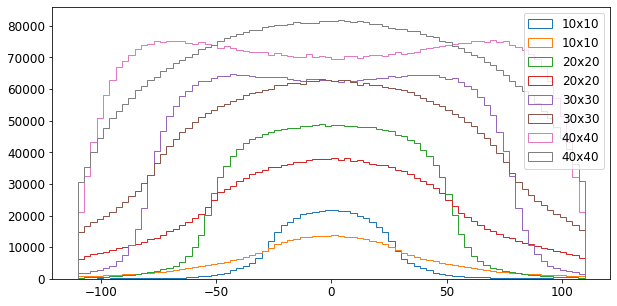

In [26]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:
        df=data_frame_dict[files_g]
        y,x,_=plt.hist(df['Y'],histtype='step',bins=(80),label=files_g[30:-33])
        y,x,_=plt.hist(df['X'],histtype='step',bins=(80),label=files_g[30:-33])
#         print(f"{midpoints(y)} and x {x}")

# plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
# plt.ylim(0.001,1.2)
plt.show()

In [ ]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:
        df=data_frame_dict[files_g]
        y,x,_=plt.hist(df['Ekine'],density=True,histtype='step',bins=(80),label=files_g[30:-33])
#         print(f"{midpoints(y)} and x {x}")

# plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
plt.ylim(0.001,1.2)
plt.show()

for j,yi in enumerate(y):
    print(f"/gate/source/mybeam/gps/hist/point {x[j]:.4f} {y[j]*1000:.2f}")
    
    
    

In [ ]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:

        _=plt.hist(data_frame_dict[files_g]['X'],weights=data_frame_dict[files_g]['Weight'],histtype='step',bins=(80),label=files_g[30:-13])

plt.yscale('log')
plt.legend()
# plt.xlim(0,5.8)
# plt.ylim(0.001,1)
plt.show()


In [ ]:
plt.subplots(1,1,figsize=(10,5))

for files_g in filenames_g:

    _=plt.hist(data_frame_dict[files_g]['dX'][data_frame_dict[files_g]['X']<40][data_frame_dict[files_g]['X']>30],histtype='step',bins=(80),label=files_g[30:-13])

plt.yscale('log')
plt.legend(loc="upper left")
# plt.xlim(0,5.8)
# plt.ylim(0.001,1)
plt.show()


In [ ]:
filenames_g=[
            "/work/lb8075/PhaseSpaces/PhS1AB_Gamma_Params/output-PhS_bias100_3.root",\
            "/work/lb8075/PhaseSpaces/PhS1AB_Gamma_Params/output-PhS_bias1_3.root"
]


In [ ]:

data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','Weight','Ekine','ProductionVolume','CreatorProcess'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is



In [ ]:
for files_g in filenames_g:
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    print(data_frame_dict[files_g].groupby('ProductionVolume')['Weight'].sum())


In [ ]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(19,4))
# creating a temporary dataframe to hold the one we're currently interating over
    df=data_frame_dict[files_g]
    np2=df['CreatorProcess'].to_numpy(dtype="str")
    np3=df['Weight'].to_numpy(dtype="float16")
    np2=np2.astype('str')
    print(np2.dtype)
    print(np3.dtype)

# plt.hist(df['ProductionVolume'])
# print(df.dtypes)
# df['ProductionVolume']=df['ProductionVolume'].astype('str')
# print(df.dtypes)

#     df['Weight'].astype('float16')
# print(df.dtypes)

# print(df2)
# _=plt.hist(df3)
#     plt.xlim(-100,100)
#     plt.ylim(-100,100)
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.colorbar()
# plt.show()
# df2=df['ProductionVolume']
# print(df['ProductionVolume'].dtypes)
# df['ProductionVolume']=df['ProductionVolume'].astype('str')
# print(df['ProductionVolume'].dtypes)

#     df['CreatorProcess'].value_counts().plot(kind='bar',logy=True, ylim=(1,5500000))
    plt.hist2d(np2,np3)

## Inspecting phase 1A

In [ ]:
filenames_g=[
            "/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root",\
            "/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root"
]

#ran 10x more bias 1 than bias 100

In [ ]:
data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','Weight','Ekine','ParticleName','ProductionVolume','CreatorProcess'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is



In [ ]:
for files_g in filenames_g:
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    print(data_frame_dict[files_g].groupby('ProductionVolume')['Weight'].sum())


In [ ]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(10,5))
    print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    df=data_frame_dict[files_g]
    df['CreatorProcess']=df['CreatorProcess'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
    (df['CreatorProcess'][df['Weight']>0.5]).value_counts().plot(kind='bar')
    

In [ ]:
plt.subplots(1,1,figsize=(10,5))
print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
df['ProductionVolume']=df['ProductionVolume'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
(df['ParticleName'][df['Weight']<0.5]).value_counts().plot(kind='bar',logy=True,ylim=(1,10000000))
                   
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(10,5))
    print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    df=data_frame_dict[files_g]
    df['ProductionVolume']=df['ProductionVolume'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
    (df['ParticleName'][df['Weight']>0.5]).value_counts().plot(kind='bar',logy=True,ylim=(1,10000000))
    

In [ ]:
plt.subplots(1,1,figsize=(7,3))
print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
df['ProductionVolume']=df['ProductionVolume'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
(df['ProductionVolume'][df['Weight']<0.5]).value_counts().plot(kind='bar',sort_columns=True)
    
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(7,3))
    print(files_g)
#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    df=data_frame_dict[files_g]
    df['ProductionVolume']=df['ProductionVolume'].astype("str")

#     df['Weight'][df['Weight']<0.5].plot(kind='bar')
#     (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar')
    (df['ProductionVolume'][df['Weight']>0.5]).value_counts().plot(kind='bar',sort_columns=True)
    

In [ ]:
for files_g in filenames_g:
    plt.subplots(1,1,figsize=(10,5))

#     print(data_frame_dict[files_g]['ProductionVolume'].value_counts())
    df=data_frame_dict[files_g]
#     df['ProductionVolume']=df['ProductionVolume'].astype("str")

    df['Weight'].hist()

In [ ]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['X'].count())

In [ ]:
for files_g in filenames_g:
    print(data_frame_dict[files_g]['Weight'].value_counts())

In [ ]:
for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    if j==0:
        col="cyan"
    else:
        col="magenta"
    plt.hist(df['X'],density=True,weights=df['Weight'],histtype='step',color=col)

In [ ]:
for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    if j==0:
        col="cyan"
    else:
        col="magenta"
    plt.hist(df['Ekine'],density=True,weights=df['Weight'],histtype='step',color=col)

In [ ]:
for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    if j==0:
        col="cyan"
    else:
        col="magenta"
    plt.hist(df['X'][df['Y']<1],density=True,weights=df['Weight'][df['Y']<1],histtype='step',color=col)

In [ ]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    plt.hist2d(df['X'][df['ParticleName']==b'gamma'],df['Y'][df['ParticleName']==b'gamma'],weights=df['Weight'][df['ParticleName']==b'gamma'],bins=(60,60))

In [ ]:
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
dfsubgamma=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['Weight']>0.5][df['ParticleName']==b"gamma"]
dfsubgamma["ProductionVolume"].value_counts().plot(kind='bar',logy=True)

In [ ]:
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
df
# dfsubgamma=df[df['CreatorProcess']==b'eBrem']
# dfsubgamma

In [ ]:
dfsubgamma=df[df['ProductionVolume']==b'target_log'][df['Weight']>0.5][df['ParticleName']==b'gamma']
dfsubgamma

In [ ]:
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
dfsubelec=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['Weight']>0.5][df['ParticleName']==b"e-"]
dfsubelec["ProductionVolume"].value_counts().plot(kind='bar')

In [ ]:
pd.set_option('display.max_rows',1000)


In [ ]:
df1=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias1_3.root"]
dfsubgamma=df1[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df1['ParticleName']==b"gamma"]
dfsubgamma["ProductionVolume"].value_counts().plot(kind='bar',logy=True)


In [ ]:
# plt.subplots(1,1,figsize=(15,10))

for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    dfsubgamma=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['ParticleName']==b"gamma"]
    # dfsubgamma["ProductionVolume"].value_counts().plot(kind='bar',logy=True)
    print(dfsubgamma.groupby('ProductionVolume')['Weight'].value_counts())
    print("")

In [ ]:
plt.subplots(1,1,figsize=(10,4))
df["ProductionVolume"][df['ParticleName']==b"gamma"].hist(histtype='bar', weights=df['Weight'][df['ParticleName']==b"gamma"])

In [ ]:
df=data_frame_dict["/work/lb8075/PhaseSpaces/PhS1A_Gamma/output-1A_bias100_3.root"]
dfsubgamma=df[["ProductionVolume","CreatorProcess","ParticleName","Weight"]][df['ParticleName']==b"gamma"]
# dfsubgamma["ProductionVolume"].value_counts().plot(kind='bar',logy=True)[df['ParticleName']==b"gamma"]
df["ProductionVolume"][df['ParticleName']==b"gamma"].hist(histtype='bar', weights=df['Weight'][df['ParticleName']==b"gamma"])

In [ ]:
plt.subplots(1,1,figsize=(15,10))

for j,files_g in enumerate(filenames_g):
    df=data_frame_dict[files_g]
    print(files_g)
    if j==0:
        col="cyan"
        factor=10
    else:
        col="magenta"
        factor=1
    df["ProductionVolume"][df['ParticleName']==b"gamma"].hist(histtype='step',log=True, weights=factor*df['Weight'][df['ParticleName']==b"gamma"],color=col)

In [ ]:
filenames_g=[
            "/work/lb8075/PhaseSpaces/PhS1AB_Gamma_ZeroBias/output-PhS_bias1_76.root"
]

In [ ]:
data_frame_dict={}

for files_g in filenames_g:
    print(f"{files_g}   \n")
    ur=uproot.pandas.iterate(files_g, "PhaseSpace", ['X','Y','dX','dY','dZ','Weight','Ekine','ProductionVolume','CreatorProcess'])
    #This creates a set of dataframes for each files as it iterates through the * wildcards
    mylist=list(ur)        
    data_frame_dict[files_g]=pd.concat(mylist, ignore_index=True, sort=False  ,copy = False)
    #The concat method then stitches all the pandas data frames for each file together into one data frame
    #which is then stored in a dictionary, accessed by the the key files_g, whatever the filename is


In [ ]:
for j,files_g in enumerate(filenames_g):

    df=data_frame_dict[files_g]
    data_frame_dict[files_g]['dXdY']=(data_frame_dict[files_g].dX**2+data_frame_dict[files_g].dY**2)**0.5
    ratioThetaXY=data_frame_dict[files_g].dXdY/data_frame_dict[files_g].dZ
    ratioThetaX=data_frame_dict[files_g].dX/data_frame_dict[files_g].dZ
    ratioThetaY=data_frame_dict[files_g].dX/data_frame_dict[files_g].dZ
    data_frame_dict[files_g]['thetaXY']=ratioThetaXY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaX']=ratioThetaX.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['thetaY']=ratioThetaY.apply(math.atan)*180/3.14
    data_frame_dict[files_g]['XY']=(data_frame_dict[files_g].X**2+data_frame_dict[files_g].Y**2)**0.5


In [ ]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    plt.hist2d(df['X'],df['Y'],weights=df['Weight'],bins=(60,60))
    plt.colorbar()

In [ ]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    _=plt.hist2d(df['X'][df['Y']<10][df['Y']>-10],df['thetaX'][df['Y']<10][df['Y']>-10],weights=df['Weight'][df['Y']<10][df['Y']>-10],bins=(200,200))
    plt.ylim(-30,30)
    plt.colorbar()

In [ ]:
for j,files_g in enumerate(filenames_g):
    plt.subplots(1,1,figsize=(6,5))

    df=data_frame_dict[files_g]

    _=plt.hist2d(df['XY'],df['thetaXY'],weights=df['Weight'],bins=(100,200))
    plt.ylim(-20,0)
    plt.colorbar()